# HarvestStat Data Profiling - Afghanistan

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32642' # Afghanistan
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/AF_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Afghanistan',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 2000	 | AF2000A1 | 32	| AF2000A2	| 330	| nan	| 0	|
| 2005	 | AF2005A1 | 34	| nan	| 0	| nan	| 0	|
| 2013	 | AF2013A1 | 34	| AF2013A2	| 399	| nan	| 0	|
| 2017	 | AF2017A1 | 34	| AF2017A2	| 401	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_1'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])
# 3. Remove duplicate and invalid data 
pub_name_remove = 'Afghanistan Statistical Yearbook, 2016-2017'
df = df[df['publication_name'] != pub_name_remove]
src_name_remove = 'Afghanistan Statistical Yearbook (2019-10-28)'
df = df[df['source_document'] != src_name_remove]
cont1 = df['publication_name'] == 'Afghanistan Statistical Yearbook 2017-18, Issue: 39, August 2018'
cont2 = df['season_year'] == 'Autumn harvest 2017'
cont3 = df['product'] == 'Wheat Grain'
df = df[~(cont1 & cont2 & cont3)]
# 4. (Temporary) Switch 2018A1 to 2017A1 with some name modifications
df['level'] = df['fnid'].apply(lambda x: x[:8])
df_main = df[df['level'] != 'AF2018A1']
df_part = df[df['level'] == 'AF2018A1']
df_part['admin_1'] = df_part['admin_1'].replace({'Hirat':'Herat','Maidan Wardak':'Wardak', 'Sar-e-Pul':'Sar-e-Pul'})
df_part['fnid'] = df_part['fnid'].apply(lambda x: 'AF2017'+x[6:])
df = pd.concat([df_main,df_part],axis=0)
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([
    AF_Admin1_2005, AF_Admin1_2017
], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 9,777
Removed 907 "Missing Value" points
0/684 "Area Harvested" points are retained.
2,985/3,031 "Area Planted" points are retained.
2,945/3,031 "Quantity Produced" points are retained.
2,940/3,031 "Yield" points are retained.
Current data points: 8,870

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 2008 - 2019
13 grain types are found: Almond (unspecified), Apple (unspecified), Barley (Unspecified), Cotton (Unspecified), Grape (unspecified), Maize (Corn), Maize Grain (Yellow), Peach (unspecified), Pomegranate, Rice (Paddy), Saffron, Soybean (unspecified), Wheat Grain
3 seasons are found: Autumn harvest (10-01), Summer harvest (07-01), Spring harvest (05-01)
1 crop production system are found: none
Data sources include:
[1] MAIL, Afghanistan --- Afghanistan Agricultural Annual Report
[2] MAIL, Afghanistan --- Afghanistan Agricultural Annual Report 

- Afghanistan crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-afghanistan.png?itok=syYg1jn1"  width=900><br>

<img src="https://ipad.fas.usda.gov/countrysummary/images/AF/cropcalendar/stans_af_calendar.png"  width=900><br>

<img src="../figures/crop_calendar/Afghanistan_-_Crop_calendar.jpg"  width=900><br>

- FDW data consists of `AF2005A1` and `AF2017A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 2000	 | AF2000A1 | 32	| AF2000A2	| 330	|
| 2005	 | AF2005A1 | 34	| - | 0	| nan	|
| 2013	 | AF2013A1 | 34	| AF2013A2	| 399	|
| 2017	 | **`AF2017A1`** | 34	| AF2017A2	| 401	|

- Comparison between admin boundaries.

<img src="../figures/AF_admin_shapes.png"  width=900>

- **`AF2017A1`** is used to represent current admin-level 1 crop data.
- Afghanistan has 3 crop seasons: `Spring (07-01)`, `Summer (08-01)` and `Winter (11-01)`.
- Afghanistan has no crop production system.
- Afghanistan has no population group.

### Transition to auxiliary data source
- Current FDW-AF data has several problems. Therefore, we use an auxiliary data source ("Wheat production 2002-2019 by province and region.xlsx"). 
- We note that we cannot share this with others at this point. 


In [4]:
container = []
for year in np.arange(2002,2023):
    fn = '../data/auxiliary/afghanistan/Wheat production 2002-2023.xlsx'
    df = pd.read_excel(fn, sheet_name=str(year), index_col=1, skiprows=3)
    df = df.loc[~df.index.isin([np.nan,'NORTH','NORTH-EAST','WEST','WEST-CENTRAL','CENTRAL','SOUTH','EAST','SOUTH-WEST'])]
    df = df[df.columns[1:7]]
    df = df.replace({' ':0})
    # Recalculate yield
    df *= 1000
    df.iloc[:,1] = df.iloc[:,2].divide(df.iloc[:,0]).fillna(0)
    df.iloc[:,4] = df.iloc[:,5].divide(df.iloc[:,3]).fillna(0)
    mdx = pd.MultiIndex.from_product([[year],['irrigated','rainfed'],['area','yield',
    'production']])
    df.columns = mdx
    df = df.astype(float)
    container.append(df)
df = pd.concat(container, axis=1)
df = df.T.stack().reset_index()
df.columns = ['year','crop_production_system','indicator','admin_1','value']
df['value'] = df['value'].fillna(0)
# Change admin name to be consistent with FEWS NET boundary names
df['admin_1'] = df['admin_1'].replace({
    'Daikunde':'Daykundi',
    'Heart':'Herat',
    'Bughlan':'Baghlan',
    'Sar-i-Pul':'Sari Pul',
    'Helmand':'Hilmand',
    'Juzjan':'Jawzjan',
    'Kunarha':'Kandahar',
    'Nooristan**':'Nuristan'
})

# Adding geographic information
df = df.merge(AF_Admin1_2017[['FNID','ADMIN1']], left_on='admin_1',right_on='ADMIN1')
df[['country','country_code','admin_2','product']] = 'Afghanistan','AF',np.nan,'Wheat'
df['name'] = df['admin_1']
df.rename(columns={'FNID':'fnid'},inplace=True)

# Manual correction -------------------------------- #
df.loc[(df['year'] == 2004) & (df['crop_production_system'] == 'irrigated') & (df['admin_1'] == 'Panjsher') & (df['indicator'] == 'production'), 'value'] = 0
df.loc[(df['year'] == 2018) & (df['crop_production_system'] == 'irrigated') & (df['admin_1'] == 'Nimroz') & (df['indicator'] == 'area'), 'value'] = 0
# -------------------------------------------------- #

# Complete long format DataFrame ---------------- #
df['harvest_year'] = df['year']
df['planting_year'] = df['year']
df['season_name'] = df['crop_production_system'].replace({'irrigated':'Winter','rainfed':'Spring'})
df['harvest_month'] = 0
df['planting_month'] = 0
# df.loc[df['season_name']=='Winter','planting_year'] -= 1
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = df[names]
# # ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_AF.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [country, season_name] are in the external season calendar.
../data/crop/adm_crop_production_AF.csv is saved.


# Visualization of production data

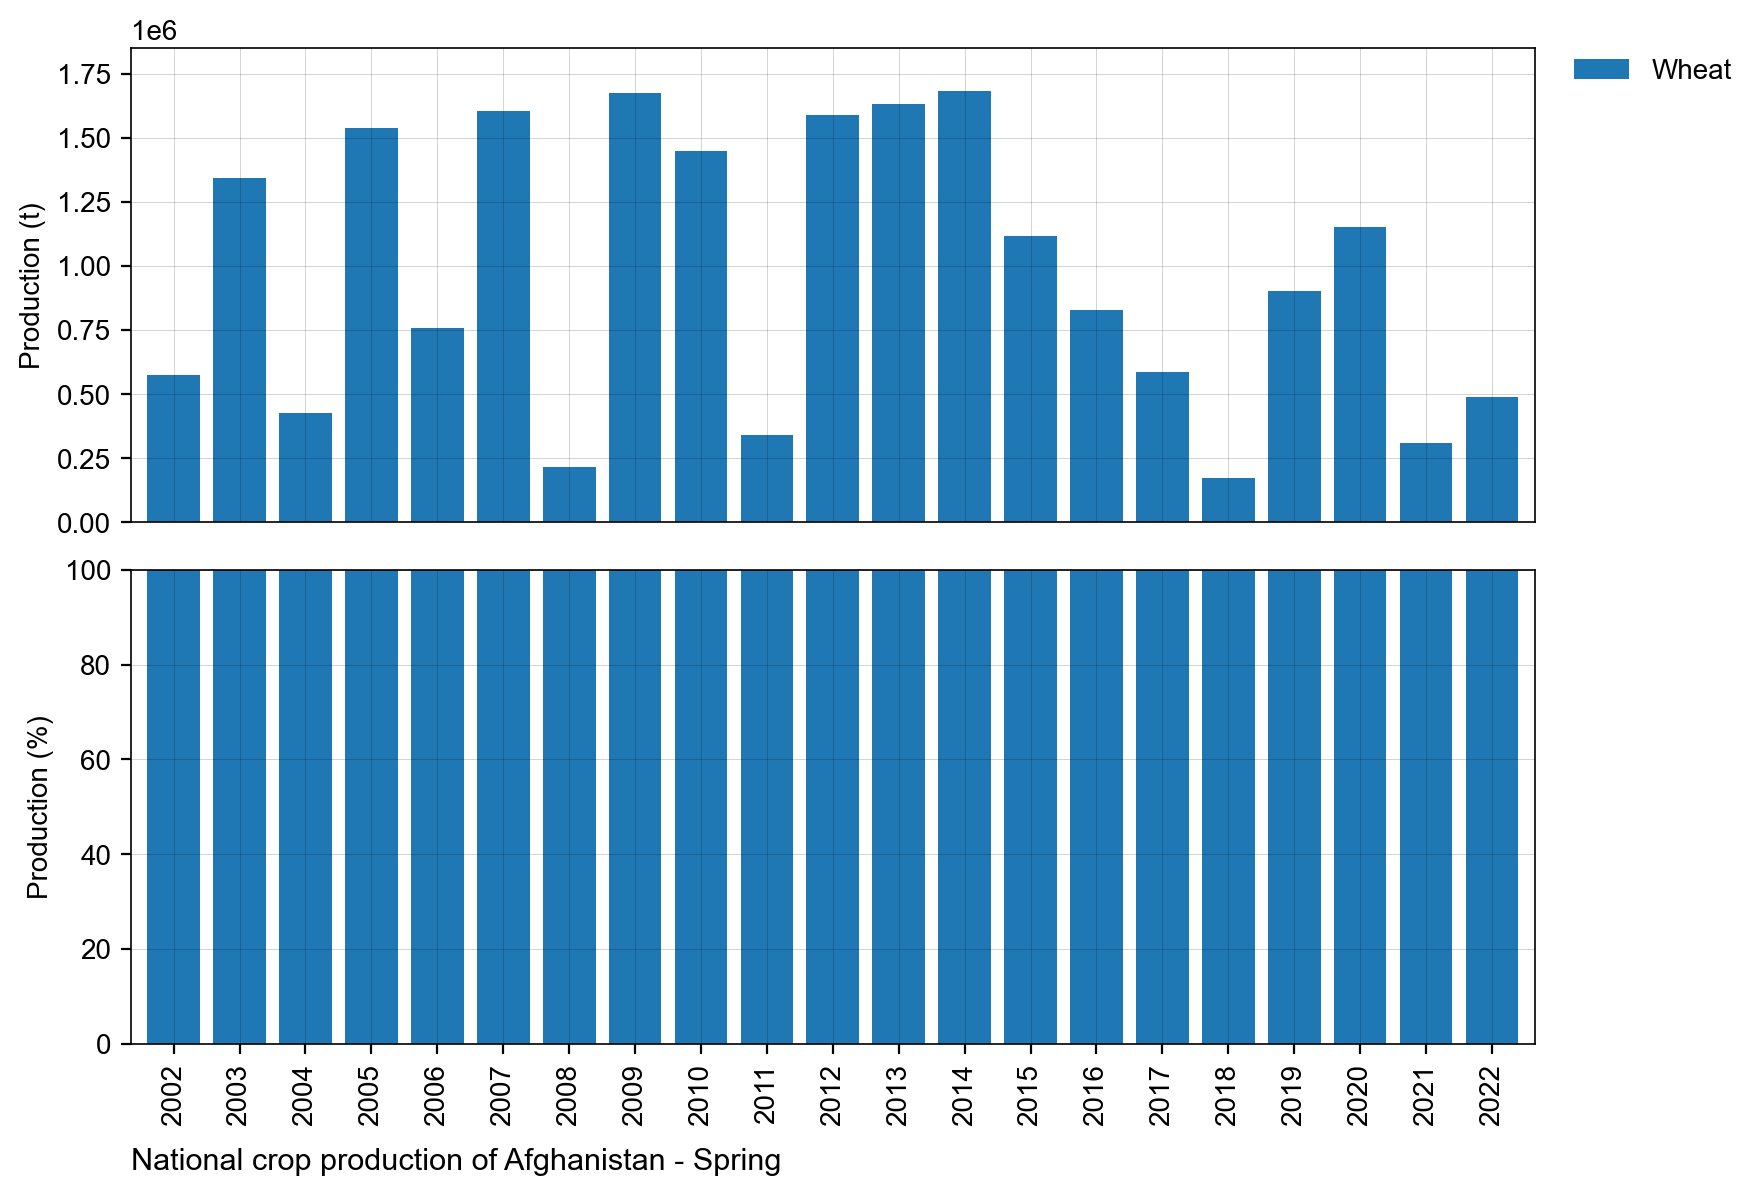

../figures/AF_bar_natgrainprod_Spring.png is saved.


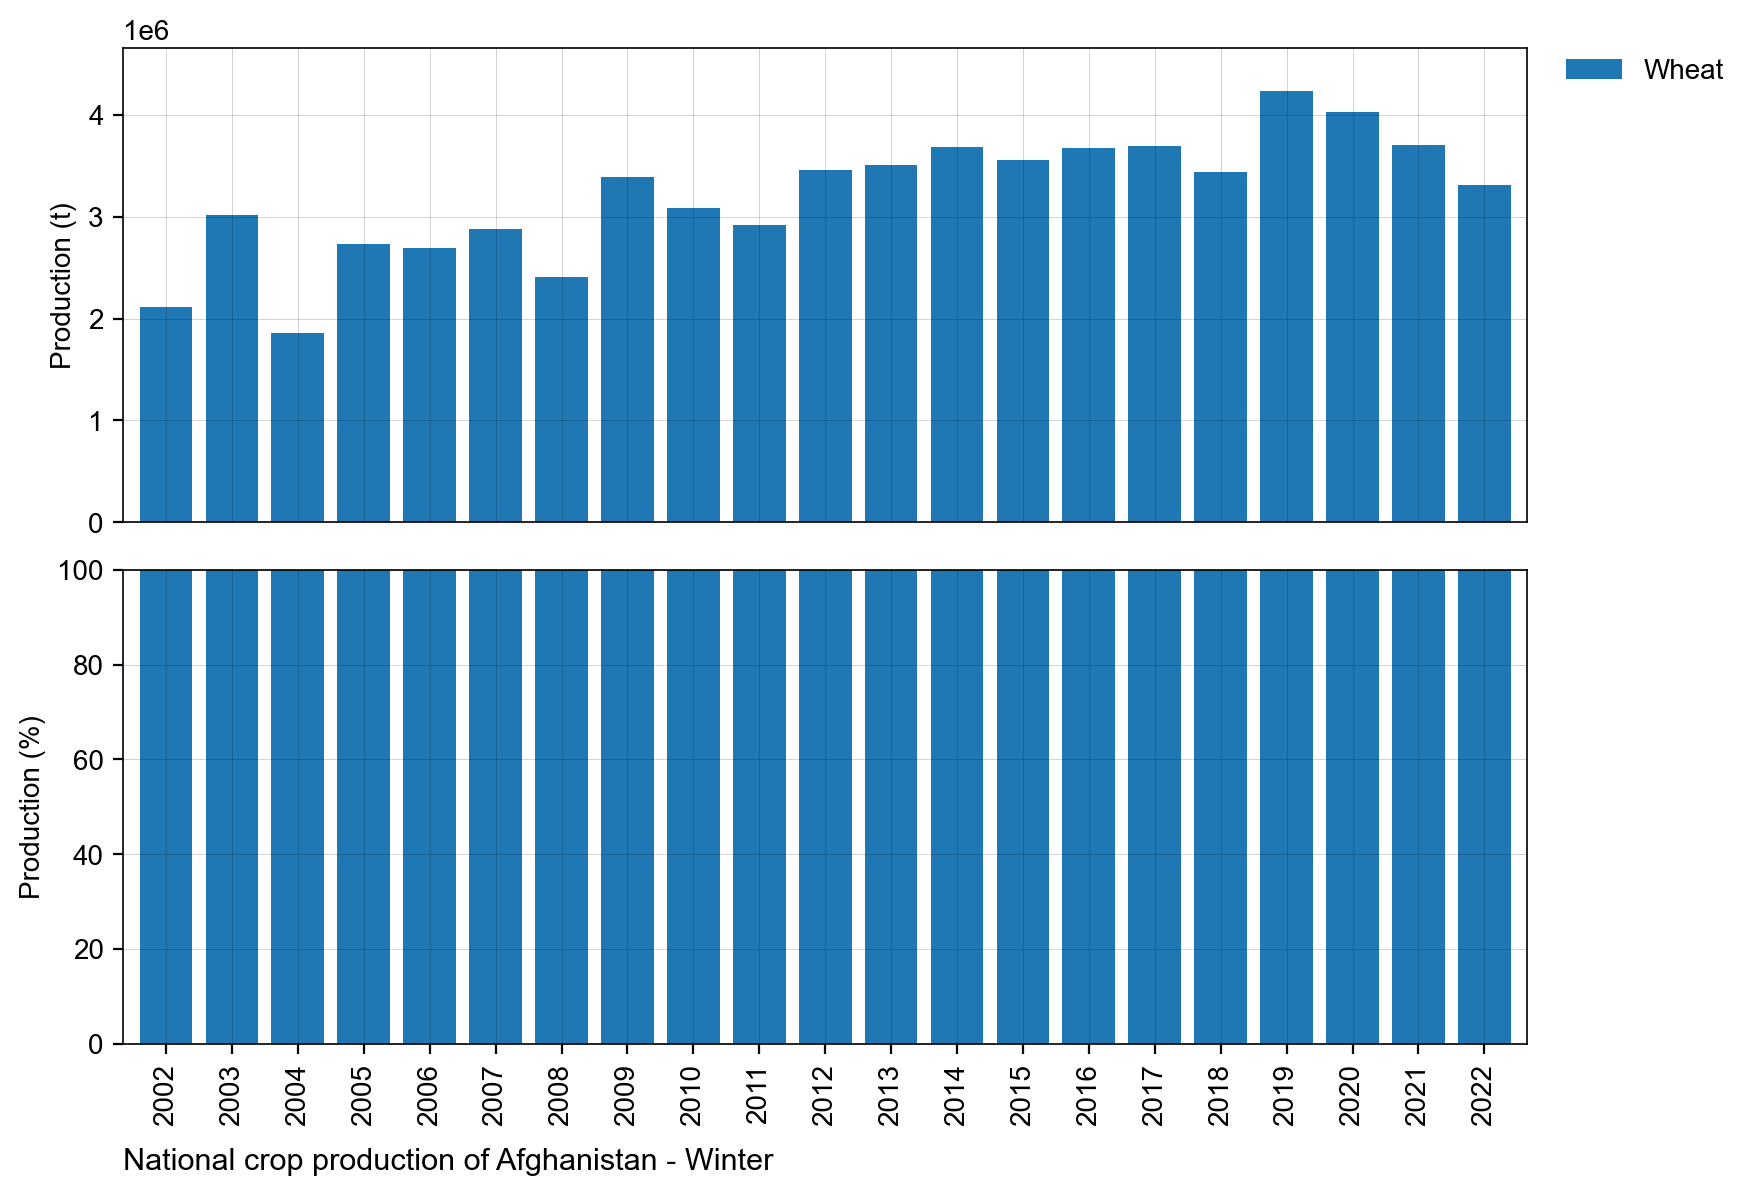

../figures/AF_bar_natgrainprod_Winter.png is saved.


In [5]:
# Bar chart of national crop production
country_iso, country_name = 'AF', 'Afghanistan'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Spring','Winter']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

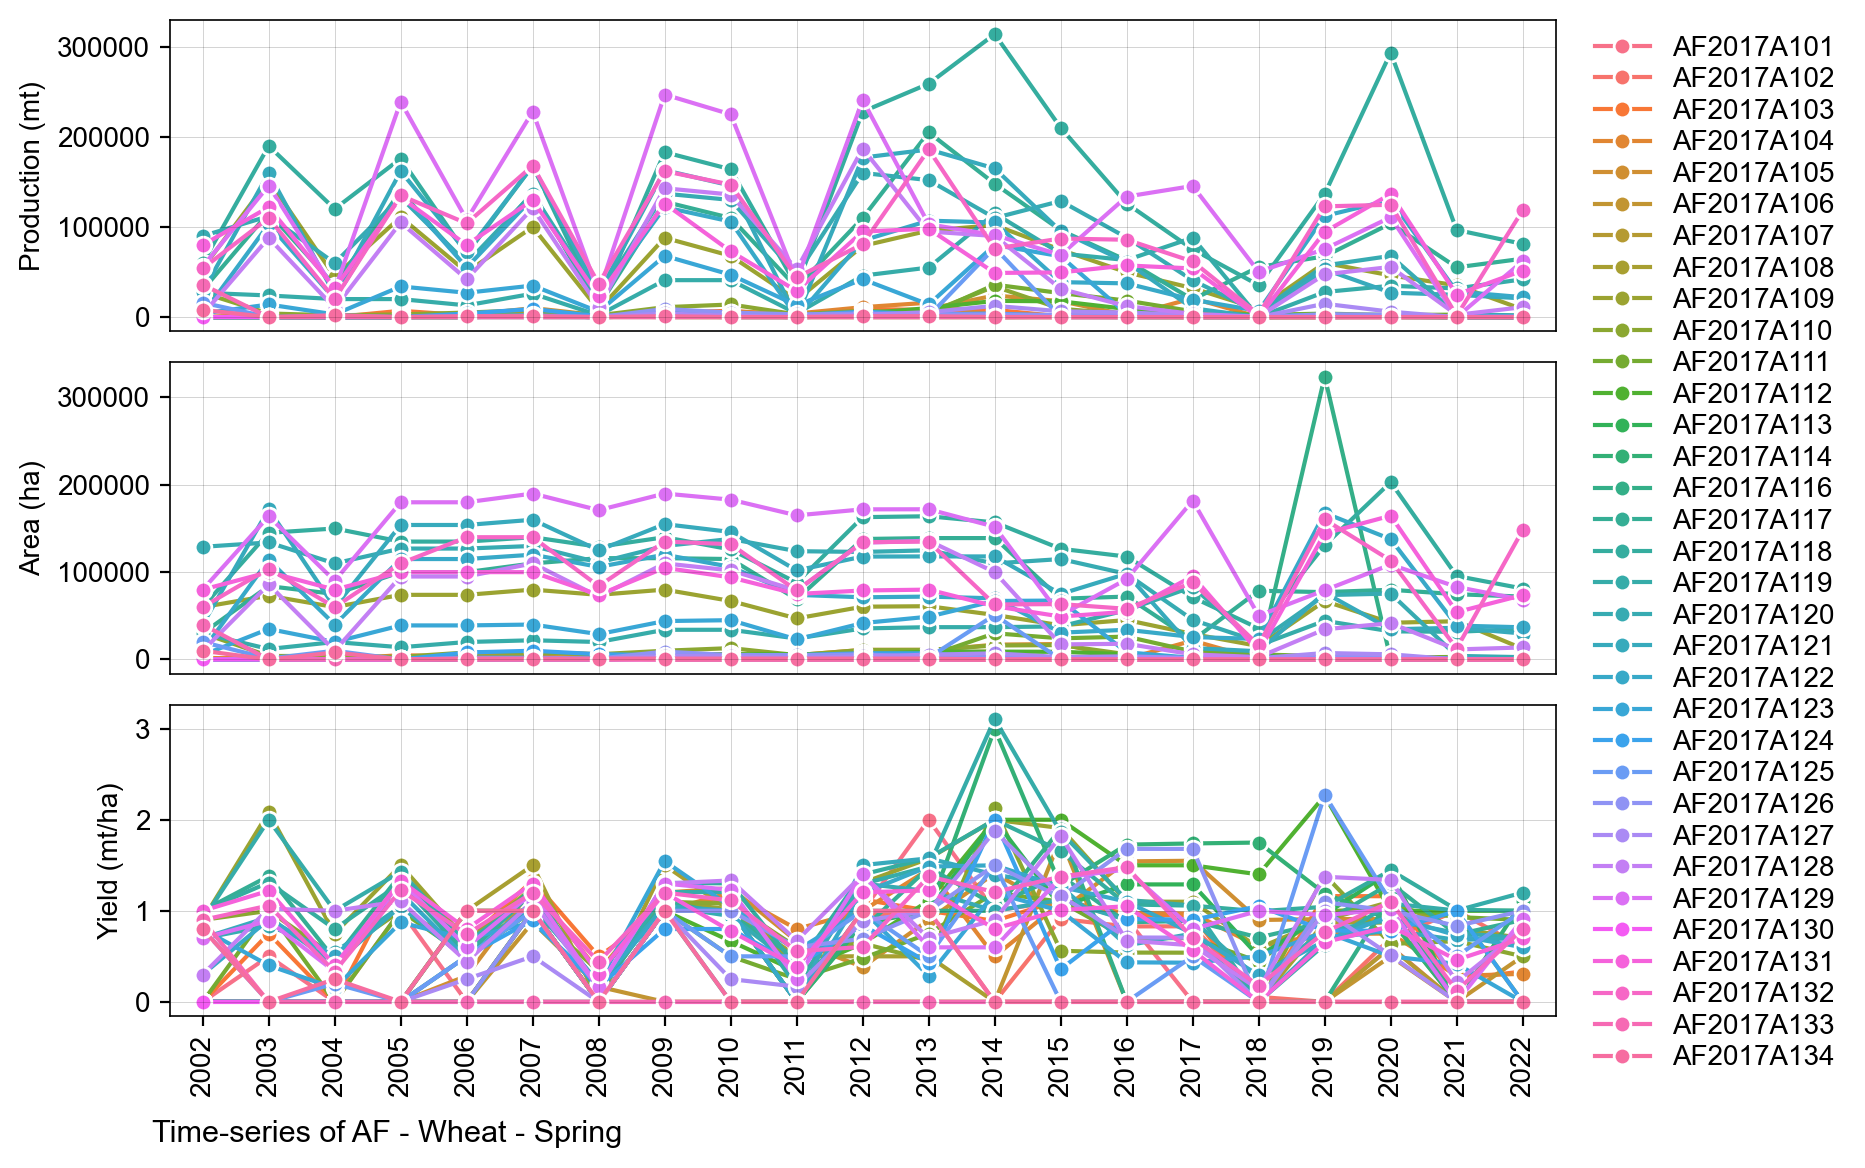

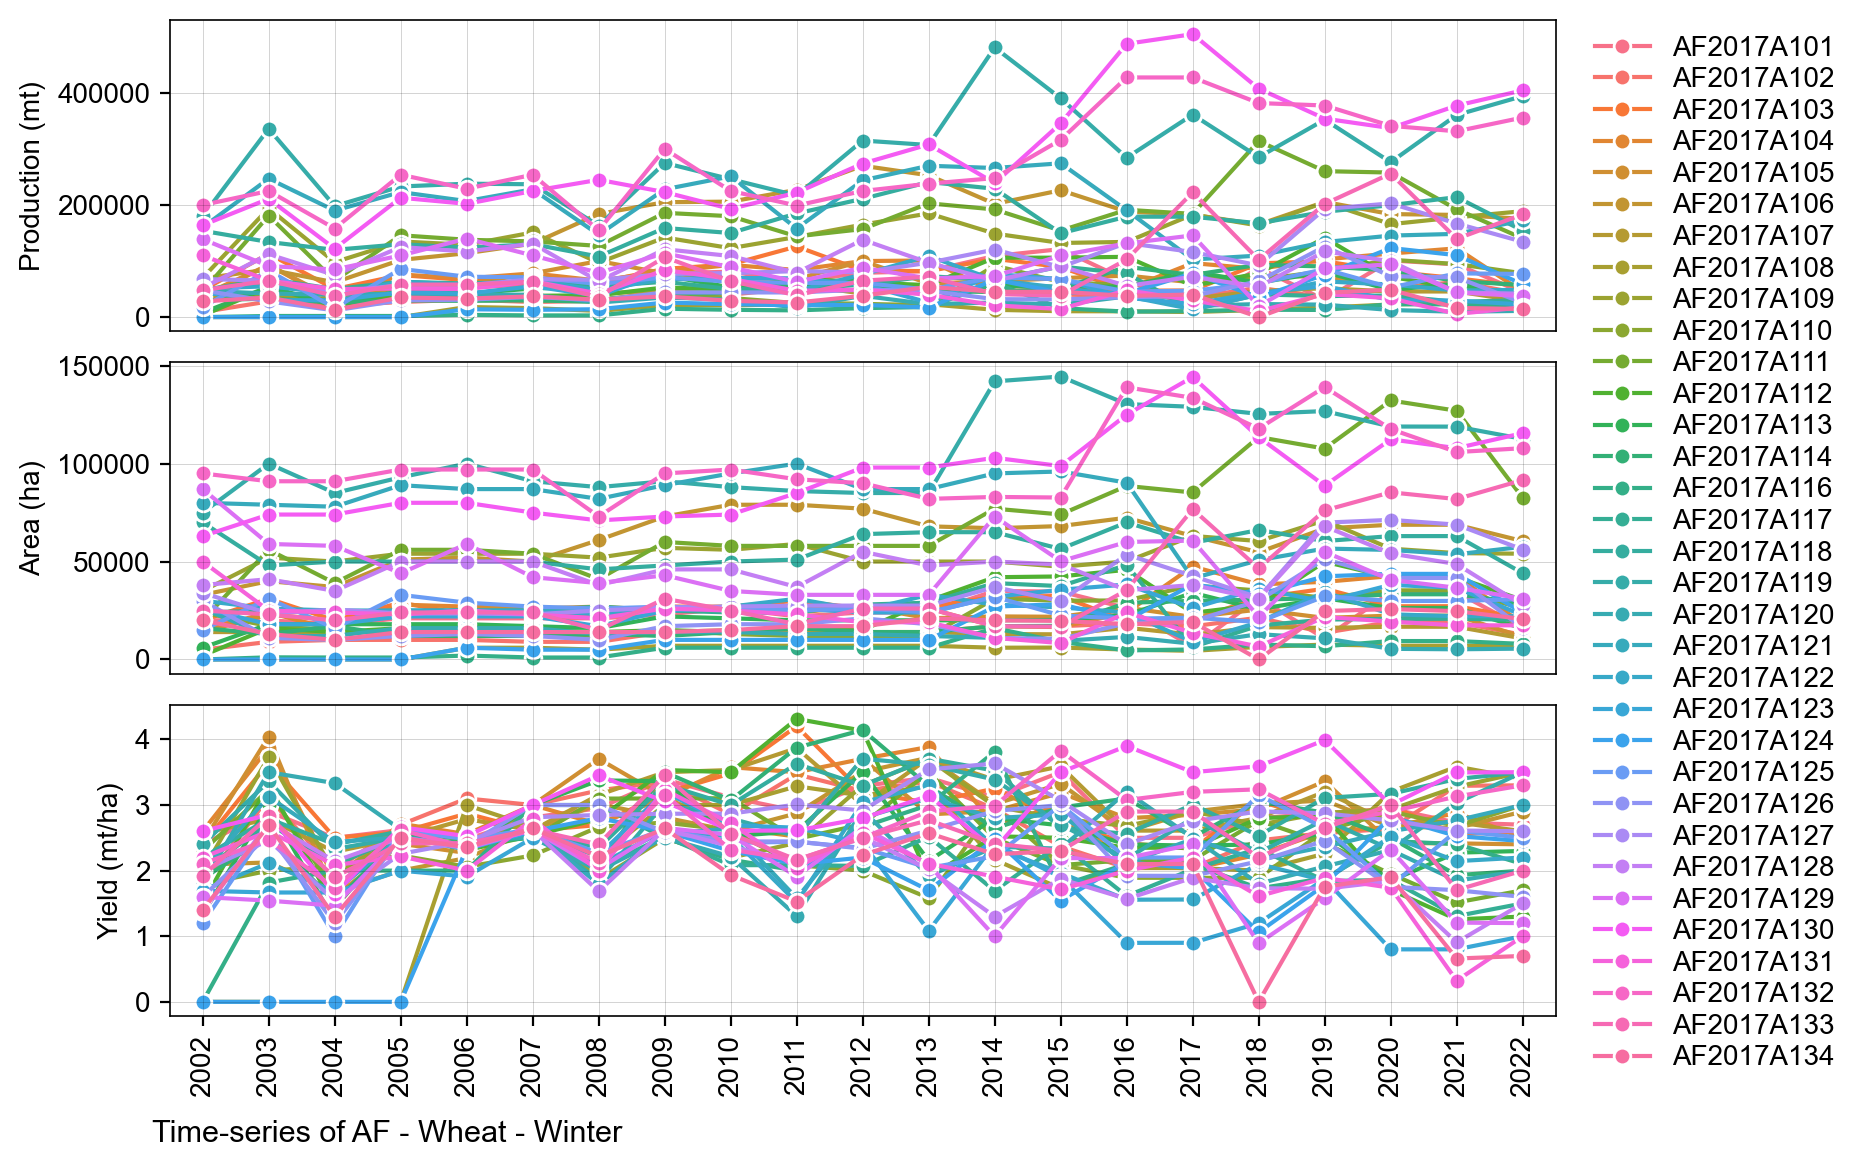

In [6]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'AF', 'Afghanistan'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Wheat','Spring'],
    ['Wheat','Winter'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)